# 간단한 RAG(Retrieval Augmented Generation) 만들기
- 검색 증강 생성
- RAG 시스템으로 사내 내부의 LLM서비스를 만들 수 있다.
- loader의 종류만 잘 알면 활용하기 쉽다.

- Lang Smith 연결

In [2]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="../99_env/.env")

True

2. 필요 패키지 설치
    - chroma: langchain vector store


In [17]:
pip install langchain langchain-chroma langchain-openai

  Using cached langchain_chroma-0.1.3-py3-none-any.whl.metadata (1.5 kB)
  Using cached chromadb-0.5.3-py3-none-any.whl.metadata (6.8 kB)
  Using cached fastapi-0.113.0-py3-none-any.whl.metadata (27 kB)
  Using cached build-1.2.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached chroma-hnswlib-0.7.3.tar.gz (31 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached uvicorn-0.30.6-py3-none-any.whl.metadata (6.6 kB)
  Using cached posthog-3.6.3-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached onnxruntime-1.19.2-cp312-cp312-win_amd64.whl.metadata (4.7 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.27.0-py3-non

In [31]:
pip install pypdf

Note: you may need to restart the kernel to use updated packages.


3. Document 생성

In [32]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("./snow-white.pdf")

docs = loader.load()
docs

[Document(metadata={'source': './snow-white.pdf', 'page': 0}, page_content='백설공주\n옛날어느왕국에공주님이 태어났어요 .\n“어쩜이렇게어여쁠까 ? 살결이눈처럼하얗구나 . 백\n설공주라고 불러야겠다 .”\n왕과왕비는갓태어난딸을보며기뻐했어요 .\n하지만기쁨도잠시, 왕비는곧세상을떠나고말았어\n요.\n'),
 Document(metadata={'source': './snow-white.pdf', 'page': 1}, page_content='왕은아름다운 새왕비를맞았어요 .\n그런데새왕비는자기보다 아름다운 사람을두고보\n지못했어요 .\n왕비는진실만을 말하는요술거울에게 늘이렇게물\n었어요 .\n“거울아 , 거울아 . 이세상에서 누가가장아름답니 ?”\n“이세상에서 가장아름다운 사람은왕비님입니다 .”\n그대답을들어야만 차가운왕비얼굴에미소가번졌\n지요.\n시간이흘러백설공주는 어여쁜소녀가되었어요 .\n어느날, 왕비는요술거울에게 물었지요 .\n“거울아 , 거울아 . 이세상에서 누가가장아름답니 ?”\n“왕비님도 아름답지만 백설공주가 더아름답습니다 .”\n화가난왕비는사냥꾼을 불렀어요 .\n왕비는사냥꾼에게 백설공주를 죽이라고 명령했어요 .\n하지만사냥꾼은 차마그럴수없었어요 .\n“가여운공주님 , 왕비님이 찾지못하도록 멀리멀리 떠\n나세요.”\n백설공주는 울면서숲으로도망쳤어요 .\n'),
 Document(metadata={'source': './snow-white.pdf', 'page': 2}, page_content='숲속을헤매던백설공주는 외딴오두막에 이르렀어요 .\n들여다보니 오두막은 비어있었어요 .\n“아무도없네. 좀쉬어가도될까? 어? 신기하다 ! 모든게작아. \n어어? 이상하다 ! 모든게일곱. 의자도일곱, 접시도일곱. 어머, \n침대도일곱개네.”\n도망치느라 치진백설공주는 식탁위에있던빵을먹고나서\n일곱번째침대에쓰러져잠들었어요 .\n밤이되자오두막주인인일곱난쟁이가 돌아왔어요 .\n난쟁이들은 집안이어질러진 것을보고깜짝놀랐지

4. split -> emved -> vector store에 저장

In [33]:
from langchain_chroma import Chroma
from langchain.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 임베딩 모델 로드
embedding_model = OllamaEmbeddings(model="gemma2:2b")

# 문서 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=10)
texts = text_splitter.split_documents(docs)

# texts # 문서 확인

# 분할된 텍스트를 임베딩 한 후 벡터스토어에 저장
vectorstore = Chroma.from_documents(
    texts,
    embedding=embedding_model
)

vectorstore

ValueError: Error raised by inference API HTTP code: 500, {"error":"llama runner process has terminated: error:failed to create context with model 'C:\\Users\\2ee42\\.ollama\\models\\blobs\\sha256-7462734796d67c40ecec2ca98eddf970e171dbb6b370e43fd633ee75b69abe1b'"}

5. VectorStore에서 유사도가 높은 문장 검색

In [30]:
sample = "왕비와 백설공주 중 누가 더 아름다울까?"

# vectorstore.similarity_search(sample)

# 검색
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k":5} # kwargs: keyword Arguments
)

retriever.batch([sample])

ValueError: Error raised by inference API HTTP code: 500, {"error":"llama runner process has terminated: exit status 0xc0000005"}

6. 유사도 높은 문장과 함께 프롬프트 생성
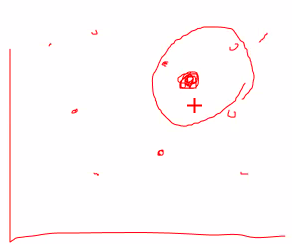

In [27]:
from langchain_core.prompts import ChatPromptTemplate

# 질문과 명령을 바인딩해서 사용한다.
message ="""
Answer this question using the provied context only. 

{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "당신은 어린아이에게 꿈과 희망으 심어주는 유치원교사입니다. 질문하는 아이의 반응에 최대한 호응해주며 context 기반으로만 답변해주세요"),
        ("human", message)
    ]
)

question = "백설공주의 이름은 왜 백설공주야?"
prompt.invoke({"context": retriever, "question": question})

ChatPromptValue(messages=[SystemMessage(content='당신은 어린아이에게 꿈과 희망으 심어주는 유치원교사입니다. 질문하는 아이의 반응에 최대한 호응해주며 context 기반으로만 답변해주세요'), HumanMessage(content="\nAnswer this question using the provied context only. \n\n백설공주의 이름은 왜 백설공주야?\n\nContext:\ntags=['Chroma', 'OllamaEmbeddings'] vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x0000018F44E0ECF0>\n")])

7. chain 생성 후 LLM 추론

In [29]:
from langchain.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough

model = ChatOllama(
    model="gemma2:2b",
    temperature=0.3
)

chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | model # chain을 prompt에 전달 prompt에서 model로 전달

chain.invoke("백설공주와 왕비 중 누가 더 아름다울까?")

AIMessage(content='백설공주의 얼굴에 햇살이 따스하게 맞아서 아름다움을 보여주는 것 같아요!  \n\n**왜냐하면, 백설공주가 눈처럼 하얗게 빛나고, 왕과 왕비도 그 모습을 보고 기뻐했답니다.** 😊 \n\n누구보다 아름다운 것은 누구일까요? 🤔  \n', response_metadata={'model': 'gemma2:2b', 'created_at': '2024-09-06T02:23:04.4947207Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 2127841400, 'load_duration': 109714100, 'prompt_eval_count': 448, 'prompt_eval_duration': 178279000, 'eval_count': 90, 'eval_duration': 1828245000}, id='run-e77b9c8c-33da-494a-9187-7b2357d88fcd-0')

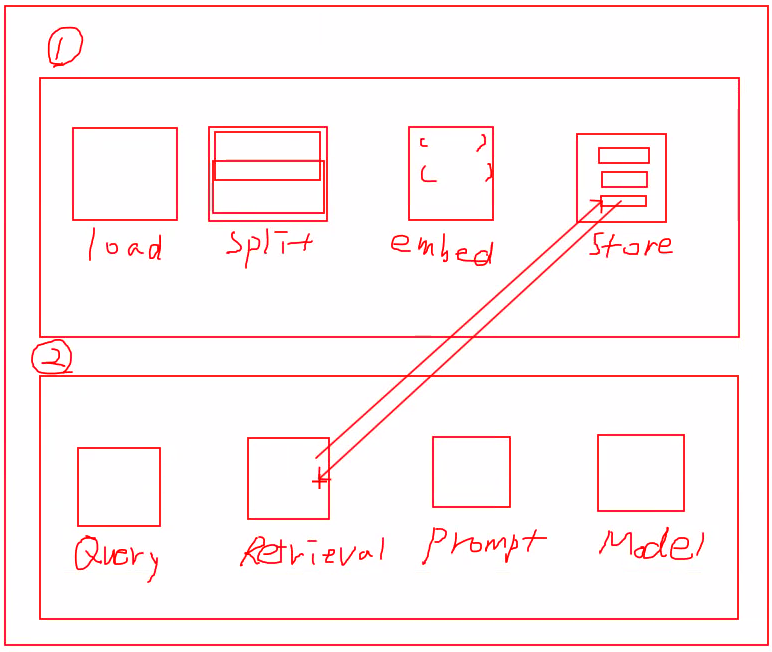 -> 같은 메모리 내에서 동작 중..
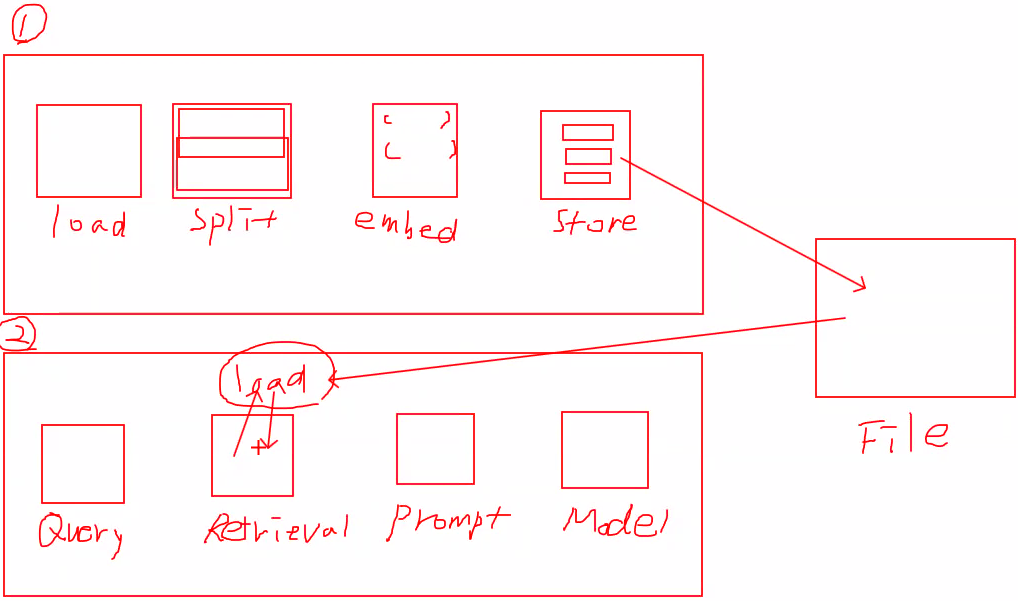

page1은 따로 만들고 page 2는 사용자가 사용할 수 있게끔 만든다.